In [1]:
from pymongo import MongoClient
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from wsba import *
%matplotlib inline
from datetime import timedelta
import random
import numpy as np
import names as randomname # for redditor anonymization
#

In [6]:
# wrote a name anonymizer
print(lookupName('fred'))
print(lookupName('tom'))

Inman
Wyatt


In [12]:
# Pilfered from https://towardsdatascience.com/making-matplotlib-beautiful-by-default-d0d41e3534fd
sns.set(
    #font='Franklin Gothic Book',
    rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'lightgrey',
         'axes.facecolor': 'None',
         'axes.grid': False,
         'axes.labelcolor': 'dimgrey',
         'axes.spines.right': False,
         'axes.spines.top': False,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'w',
         'patch.force_edgecolor': True,
         'text.color': 'dimgrey',
         'xtick.bottom': True,
         'xtick.color': 'dimgrey',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'dimgrey',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})


In [14]:
getnumsubmissions()

1719

In [15]:
findone()

"{'_id': ObjectId('605bb15d5df7eedfb49c1b8b'), 'id': 'mcheu3', 'fullname': 't3_mcheu3', 'selftext': '', 'created_utc': '2021-03-24 17:38:13', 'num_comments': 0, 'score': 1, 'upvote_ratio': 1.0, 'is_original_content': False, 'permalink': '/r/wallstreetbets/comments/mcheu3/ill_just_blame_it_on_my_wifes_bf_those_16_shares/', 'title': 'I’ll just blame it on my wife’s bf. Those 16 shares came from his account . 🦍 🍌 🤡 honk honk . 🍦 ICE-CREAM !!! When the —— did we get ice-cream !', 'author': 'DaveThePOKEMONGuy', 'firstseen': '2021-03-24 21:38:37.006766'}"

Here is raw mongo to sort by date:
```    
db.wsb_submissions.aggregate( [ {
   $project: {
      'date': {
         $dateFromString: {
            dateString: '$created_utc'
         }
      }
   }
}, { $sort: { 'date' : 1} } ] )
```


In [16]:
date_sorted = wsbs.aggregate( [ {
   '$project': {
      'date': {
         '$dateFromString': {
            'dateString': '$created_utc'
         }
      }
   }
}, { '$sort': { 'date' : 1} } ] )

In [17]:
for x in date_sorted:
    print(x)
    break

{'_id': ObjectId('605bb2fe5df7eedfb49c1f56'), 'date': datetime.datetime(2021, 3, 18, 15, 8, 41)}


In [20]:
def getdaterange():
    first = None
    last = None
    dates_sorted = wsbs.aggregate( [ { '$project': { 'date': { '$dateFromString': 
        { 'dateString': '$created_utc' } } } }, { '$sort': { 'date' : 1} } ] )
    for val in dates_sorted:
        first = val
        break
    dates_sorted = wsbs.aggregate( [ { '$project': { 'date': { '$dateFromString': 
        { 'dateString': '$created_utc' } } } }, { '$sort': { 'date' : -1} } ] )
    for val in dates_sorted:
        last = val
        break
    
    return (first,last)

In [21]:
first,last = getdaterange()
last['date'].strftime('%m/%d/%y')

'04/01/21'

In [22]:
def groupbyauthor(show=False, min=0):
    authors = wsbs.aggregate([{"$group":{"_id":"$author","count": { "$sum":1 }}},{"$sort":{'count':-1}}])
    most = 10
    i = 0
    post_counts = []
    posters = []
    for x in authors:
        if x['count'] > 1 and show:
            print(x)
    
        if x['count'] >= min:
            i += 1
            post_counts.append(x['count'])
            posters.append(x['_id'])
            
    return (i, posters, post_counts)
    

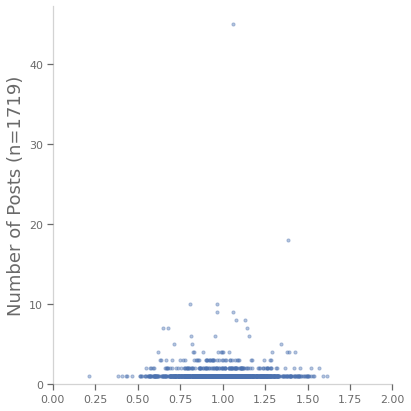

In [27]:
num, posters, post_counts = groupbyauthor()


fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(x=stats.norm.rvs(1,size=len(post_counts),scale=.2),
           y=post_counts,
           s=10,
           alpha=.4)
ax.set_ylabel(f'Number of Posts (n={sum(post_counts)})')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0,xmax=2)
plt.tight_layout()
#plt.savefig('figures/pda_numposts.png')

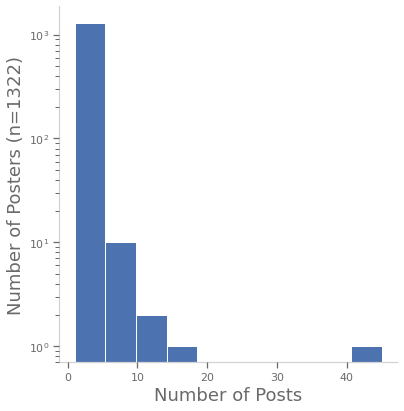

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.hist(x=post_counts)
ax.set_ylabel(f'Number of Posters (n={num})')
ax.set_xlabel('Number of Posts')
plt.tight_layout()
plt.yscale('log')
#plt.savefig('figures/pda_numposts_hist.png')

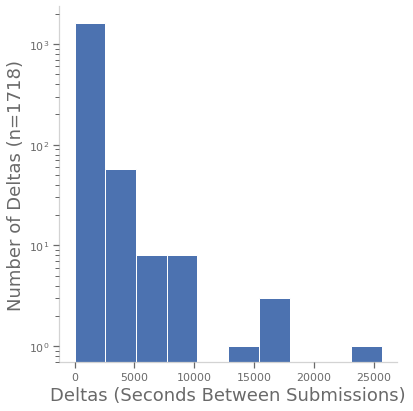

In [56]:
def getsubmissiondeltas(max=None,log=True,save=None):
    submission_dates = wsbs.aggregate( [ {
        '$project': {
            'date': {
                '$dateFromString': {
                    'dateString': '$created_utc'
                 }
             }
        }
    }, { '$sort': { 'date' : -1} } ] )
    
    i = 0
    lastTime = None
    deltas = []
    for x in submission_dates:
        i += 1
        if lastTime != None:
            delta = (lastTime - x['date']).seconds
            if max == None or delta <= max:
                deltas.append(delta)
        #print(i, x)
        lastTime = x['date']
        #if i >= 30:
        #    break
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.hist(x=deltas)
    ax.set_ylabel(f'Number of Deltas (n={len(deltas)})')
    ax.set_xlabel('Deltas (Seconds Between Submissions)')
    plt.tight_layout()
    if log:
        plt.yscale('log')
    if save:
        plt.savefig(save)
    return deltas

deltas = getsubmissiondeltas()

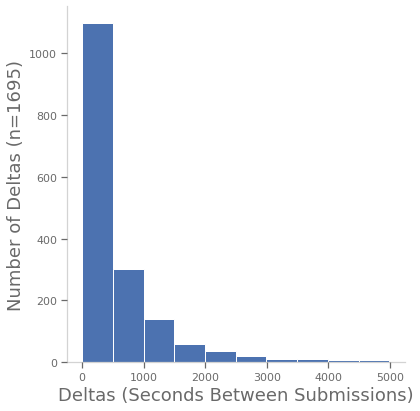

In [57]:
deltas = getsubmissiondeltas(max=5000,log=False)

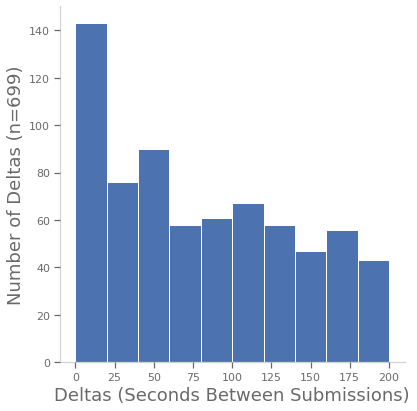

In [65]:
deltas = getsubmissiondeltas(max=200,log=False)

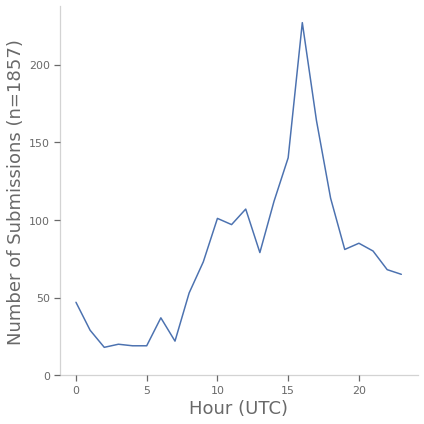

In [181]:
    
def groupby_hour(save=None):
    first = None
    last = None
    
    dates_sorted = wsbs.aggregate( [ 
        {
            '$project': {
                'hour': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%H"
                    }
                }
            }
        },
        {
            "$group": { 
                '_id':"$hour" ,
                'numsubmissions': { '$sum':1 }
            }#z
            
        },
        {
            "$sort":  { '_id': 1 } # This worked when there was a groupby for only a single field
            #"$sort":  { '_id': {'day':1, 'hour':1} }
        }
    ] )
    i = 0
    hours = []
    submissions = []
    for val in dates_sorted:
        hours.append(int(val['_id']))
        submissions.append(int(val['numsubmissions']))
        i += 1
        if i >= 10:
            pass
        
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(hours, submissions)
    ax.set_ylabel(f'Number of Submissions (n={sum(submissions)})')
    ax.set_xlabel('Hour (UTC)')
    plt.gca().set_ylim(bottom=0)
    plt.tight_layout()
    if save:
        plt.savefig(save)
    
    
groupby_hour()

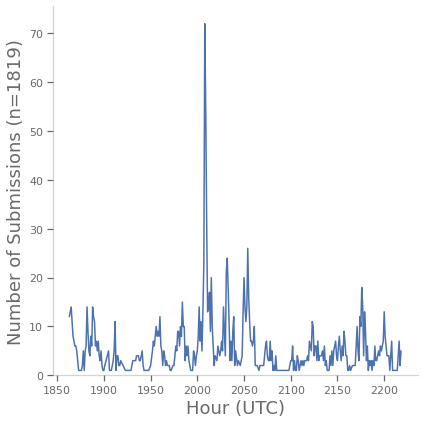

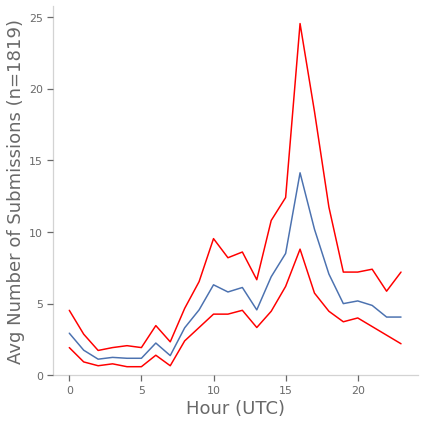

In [177]:
def groupby_monthday_hour():
    first = None
    last = None
    
    dates_sorted = wsbs.aggregate( [ 
        {
            '$project': {
                'hour': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%H"
                    }
                },
                'monthday': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%m%d"
                    }
                }
            }
        },
        {
            "$group": { 
                '_id':{'day':'$monthday','hour':"$hour"} ,
                'numsubmissions': { '$sum':1 }
            }#z
            
        },
        {
            "$sort":  { '_id': 1 } # This worked when there was a groupby for only a single field
            #"$sort":  { '_id': {'day':1, 'hour':1} }
        }
    ] )
    i = 0
    hours = []
    submissions = []
    for val in dates_sorted:
        #hours.append(int(val['_id']))
        submissions.append(int(val['numsubmissions']))
        print(val)
        i += 1
        if i >= 10:
            pass
        #break
    return
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(hours, submissions)
    ax.set_ylabel(f'Number of Submissions (n={sum(submissions)})')
    ax.set_xlabel('Hour (UTC)')
    plt.gca().set_ylim(bottom=0)
    plt.tight_layout()

    
def posts_per_hour(save=[None,None]):
    def hour_of_year(month,day,hour):
        '''given an hour, day, and month, return the number of hours since the beginning of the year'''
        dayspermonth =[0,31,28,31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        return hour + day*24 + sum(dayspermonth[:month]) * 24
    
    def add_zeros(num_hourly_submissions, num):
        '''
        adds zeros to each hourly submission until the total number of data points equals num
        '''
        for i, hour in enumerate(num_hourly_submissions):
            while len(num_hourly_submissions[i]) < num:
                num_hourly_submissions[i].append(0)
        return num_hourly_submissions
    
    def calc_avg_submissions_each_hour(num_hourly_submissions, num_days):
        '''
        given a list of submissions each hour, calculate the average number
        of submissions for each hour and return that in a list.
        
        num_days - used as the denominator in the calculation of the average
        '''
        submissions_each_hour = []
        for i, hour in enumerate(num_hourly_submissions):
            submissions_each_hour.append( sum(hour) / num_days)
        return submissions_each_hour
    
    def calc_bootstrap(num_hourly_submissions, num_samples=60_000):
        strap_space = np.zeros((24,num_samples))
        
        for hour, hour_sample_space in enumerate(num_hourly_submissions):
            for s in range(0,num_samples):
                strap_space[hour,s] = sum(random.choices(hour_sample_space,k=len(hour_sample_space))) / len(hour_sample_space)
        
        #print(strap_space)
        return strap_space
    
    dates_sorted = wsbs.aggregate( [ 
        {
            '$project': {
                'month': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%m"
                    }
                },
                'day': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%d"
                    }
                },
                'hour': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%H"
                    }
                }
            }
        },
        {
            "$group": { 
                '_id':{'month':'$month','day':'$day','hour':"$hour"} ,
                'numsubmissions': { '$sum':1 }
            }#z
            
        },
        {
            "$sort":  { '_id': 1 } # This worked when there was a groupby for only a single field
            #"$sort":  { '_id': {'day':1, 'hour':1} }
        }
    ] )
    i = 0
    hours = []
    submissions = []
    unique_days = []
    
    
    
    #submissions_each_hour is a list of lists
    # submissions_each_hour[0] returns a list of submissions during midnight across all days
    # submissions_each_hour[1] returns a list of submissions during 1am across all days
    # and so on
    submissions_each_hour = []
    for hour in range(0,24):
        submissions_each_hour.append([])
        
    for val in dates_sorted:
        submissions_each_hour[ int(val['_id']['hour']) ].append( int(val['numsubmissions']) )
        hours.append(hour_of_year(int(val['_id']['month']),int(val['_id']['day']),int(val['_id']['hour'])))
        submissions.append(int(val['numsubmissions']))
        unique_day = val['_id']['month'] + val['_id']['day']
        if not unique_day in unique_days:
            unique_days.append(unique_day)
        #print(val)
        i += 1
        if i >= 10:
            pass
        #break
    
    # used to choose a denominator when calculating average submissions per hour
    most_hourly_observations = 0 
    
    for i,hour in enumerate(submissions_each_hour):
        #print(f'{i}:{len(hour)} {hour}')
        if len(hour) > most_hourly_observations:
            most_hourly_observations = len(hour)
    
    submissions_each_hour = add_zeros(submissions_each_hour, most_hourly_observations)
    
    #for i,hour in enumerate(submissions_each_hour):
    #    print(f'{i}:{len(hour)} {hour}')
    
    
    
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(hours, submissions)
    ax.set_ylabel(f'Number of Submissions (n={sum(submissions)})')
    ax.set_xlabel('Hour (UTC)')
    plt.gca().set_ylim(bottom=0)
    plt.tight_layout()
    if save[0]:
        plt.savefig(save[0])
    
    bootstrap = calc_bootstrap(submissions_each_hour)
    avg_submissions_each_hour = calc_avg_submissions_each_hour(submissions_each_hour, len(unique_days))
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(range(0,24), avg_submissions_each_hour)
    ax.plot(range(0,24), np.percentile(bootstrap, 2.5, axis=1), c='red')
    ax.plot(range(0,24), np.percentile(bootstrap, 97.5, axis=1), c='red')
    ax.set_ylabel(f'Avg Number of Submissions (n={sum(submissions)})')
    ax.set_xlabel('Hour (UTC)')
    plt.gca().set_ylim(bottom=0)
    plt.tight_layout()
    if save[1]:
        plt.savefig(save[1])
    
        
posts_per_hour()

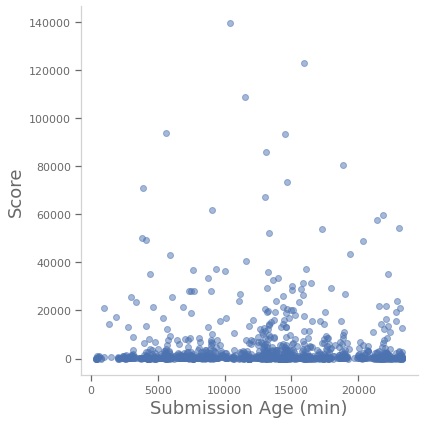

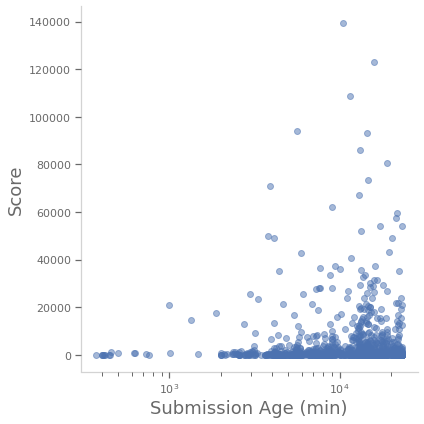

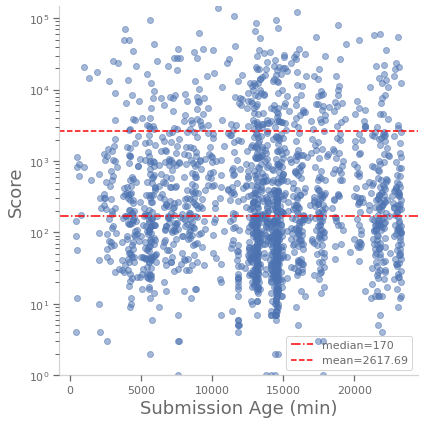

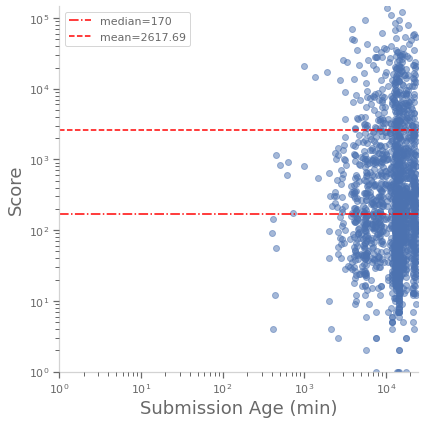

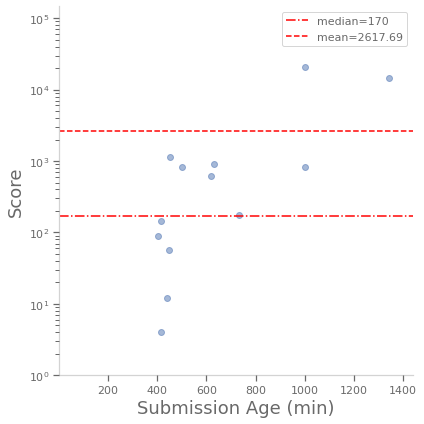

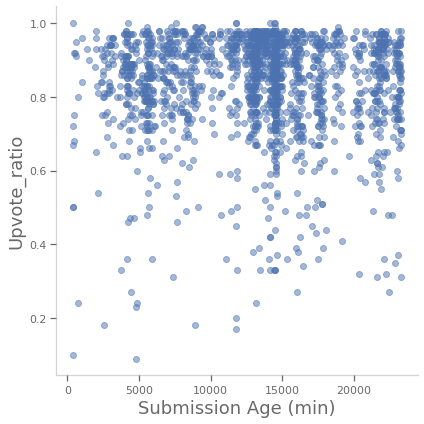

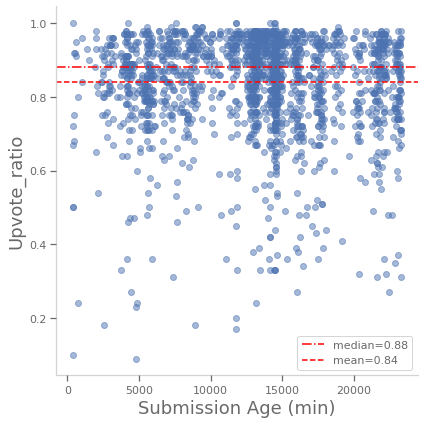

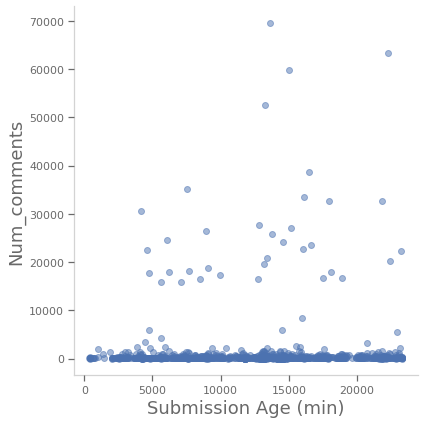

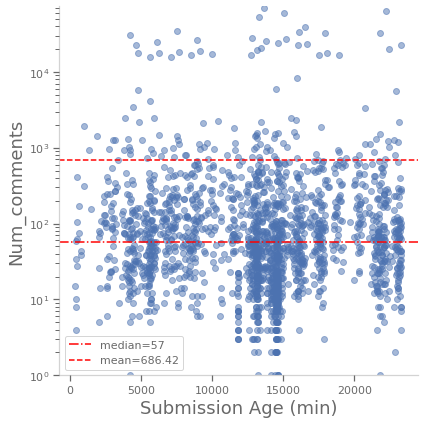

In [297]:
def fig_field_by_age(field='score',logx=False,logy=False,save=False,ymax=None,ymin=None,ymedian=False,ymean=False,xmax=None,xmin=None):
    '''
    returns the filename of a figure where some field is plotted 
    as a function of the age of the post in minutes
    '''
    age = wsbs.aggregate( [ 
        {
            '$project': {
                'minutes_old': {
                    '$divide': [
                        {
                            '$subtract': [
                                { '$dateFromString': {'dateString': '$lastseen' } },
                                { '$dateFromString': {'dateString': '$created_utc' } }
                            ]
                        }, 60_000 # per hour: 3_600_000
                        
                    ]
                },
                f'{field}': 1
            }
        }
    ] )
    
    i = 0
    data = []
    ages = []
    for item in age:
        i += 1
        data.append(item[field])
        ages.append(item['minutes_old'])

    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.scatter(ages, data, alpha=.5)
    ax.set_ylabel(field.capitalize())
    ax.set_xlabel('Submission Age (min)')
    
    if ymedian:
        from statistics import median
        ymedian = median(data)
        ax.axhline(ymedian,c='red',linestyle='-.',label=f'median={round(ymedian,2)}')
    
    if ymean:
        from statistics import mean
        ymean = mean(data)
        ax.axhline(ymean,c='red',linestyle='--',label=f'mean={round(ymean,2)}')
        
    if ymin:
        plt.gca().set_ylim(bottom=ymin)
    if ymax:
        plt.gca().set_ylim(top=ymax)
    if xmax:
        plt.gca().set_xlim(right=xmax)
    if xmin:
        plt.gca().set_xlim(left=xmin)
    
    
    
    if logx:
        plt.xscale('log')
        logx = '_logx'
    else:
        logx = ''

    if logy:
        plt.yscale('log')
        logy = '_logy'
    else:
        logy = ''
    if ymedian or ymean:
        ax.legend()
        
    plt.tight_layout()
    if save:
        filename = f'figures/{field}_by_age{logx}{logy}.png'
        plt.savefig(filename)
        print(f'![Figure]({filename})')
        return

fig_field_by_age('score')
fig_field_by_age('score',logx=True)
fig_field_by_age('score',ymin=1,logy=True, ymedian=True, ymean=True)
fig_field_by_age('score',ymin=1,logy=True, ymedian=True, ymean=True, logx=True, xmin=1)
fig_field_by_age('score',ymin=1,xmax=1440, xmin=1, logy=True, ymedian=True, ymean=True)
fig_field_by_age('upvote_ratio')
fig_field_by_age('upvote_ratio',ymedian=True, ymean=True)
fig_field_by_age('num_comments')
fig_field_by_age('num_comments',ymin=1,logy=True, ymedian=True, ymean=True)


regression; pearson r:  0.24174684929350584 1.4904527973836595e-27 0.04918163036246603
[0, 69534]
[2243.2197529718733, 40010.750328794165]
regression; pearson r:  0.6789328090847496 7.114265951196409e-261 0.3333244146926099
[0, 8340]
[51.769238697059336, 112897.77905108444]
regression; pearson r:  0.7135659914644709 3.5545688742525146e-297 0.46571265092210234
[0, 1896]
[-928.4388458996114, 38355.67758863208]
spearman_rho=0.7908208541756677   spearman_p=0.0
pearson_r=0.7135659914644705   pearson_p=3.554568874248658e-297
regression; pearson r:  0.7135659914644709 3.5545688742525146e-297 0.46571265092210234
[0, 1896]
[-928.4388458996114, 38355.67758863208]


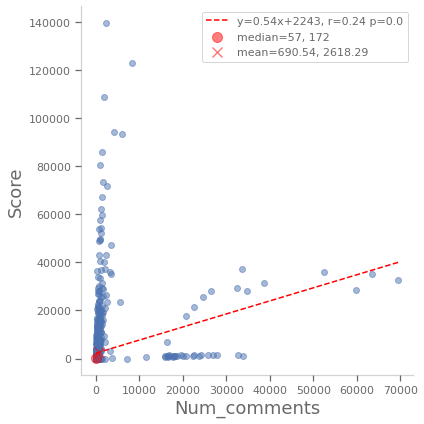

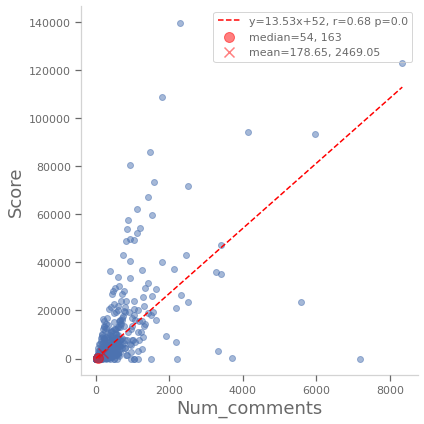

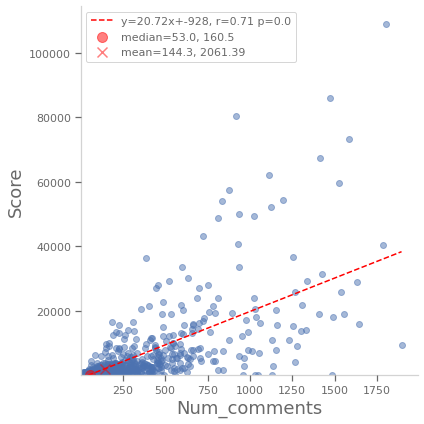

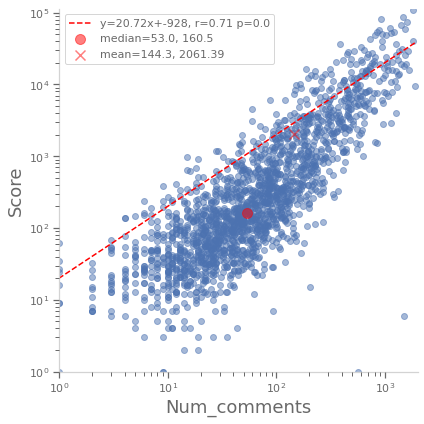

In [334]:
def fig_field_by_field(fielda='score',fieldb='score',fielda_max=None,logx=False,logy=False,save=False,ymax=None,ymin=None,median=False,mean=False,xmax=None,xmin=None,spearman=None,pearson=None,regression=None):
    '''
    returns the filename of a figure where some field is plotted 
    as a function of the age of the post in minutes
    '''
    age = wsbs.aggregate( [ 
        {
            '$project': {
                f'{fielda}': 1,
                f'{fieldb}': 1
            }
        }
    ] )
    
    i = 0
    fielda_data = []
    fieldb_data = []
    for item in age:
        if fielda_max and item[fielda] > fielda_max:
            continue
        i += 1
        fielda_data.append(item[fielda])
        fieldb_data.append(item[fieldb])

    if spearman:
        spearman_rho, spearman_p = stats.spearmanr(a=fielda_data, b=fieldb_data)
        print(f'spearman_rho={spearman_rho}   spearman_p={spearman_p}')
    
    if pearson:
        pearson_r, pearson_p = stats.pearsonr(x=fielda_data, y=fieldb_data)
        print(f'pearson_r={pearson_r}   pearson_p={pearson_p}')
    
    lr_m=0
    lr_b=0
    lr_r=0
    lr_p=0
    lr_stredd = 0
    if regression:
        lr_m, lr_b, lr_r, lr_p, lr_stredd = stats.linregress(fielda_data, fieldb_data)
        def lr(x):
            return lr_m * x + lr_b
        print("regression; pearson r: ", lr_r, lr_p, lr_stredd)
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.scatter(fielda_data, fieldb_data, alpha=.5)
    if regression:
        ax.plot([min(fielda_data),max(fielda_data)], [lr_m * min(fielda_data) + lr_b,lr_m * max(fielda_data) + lr_b],label=f'y={round(lr_m,2)}x+{round(lr_b)}, r={round(lr_r,2)} p={round(lr_p,4)}',c='red',linestyle='--')
        print([min(fielda_data),max(fielda_data)])
        print([lr_m * min(fielda_data) + lr_b,lr_m * max(fielda_data) + lr_b])
    ax.set_xlabel(fielda.capitalize())
    ax.set_ylabel(fieldb.capitalize())
    
    if median:
        median='median'
        from statistics import median
        xmedian = median(fielda_data)
        ymedian = median(fieldb_data)
        ax.scatter([xmedian],[ymedian],c='red',marker='o',s=100,label=f'median={round(xmedian,2)}, {round(ymedian,2)}',alpha=.5)
    
    if mean:
        mean='mean'
        from statistics import mean
        xmean = mean(fielda_data)
        ymean = mean(fieldb_data)
        ax.scatter([xmean],[ymean],c='red',marker='x',s=100,label=f'mean={round(xmean,2)}, {round(ymean,2)}',alpha=.5)
        
    if ymin!=None:
        plt.gca().set_ylim(bottom=ymin)
    if ymax:
        plt.gca().set_ylim(top=ymax)
    if xmax:
        plt.gca().set_xlim(right=xmax)
    if xmin!=None:
        plt.gca().set_xlim(left=xmin)
        
    if logx:
        plt.xscale('log')
        logx = '_logx'
    else:
        logx = ''

    if logy:
        plt.yscale('log')
        logy = '_logy'
    else:
        logy = ''
    if median or mean:
        ax.legend()
        
    _=plt.tight_layout()
    if save:
        filename = f'figures/{fielda}_by_{fieldb}{logx}{logy}{xmax}.png'
        _=plt.savefig(filename)
        print(f'![Figure]({filename})')
        return

fig_field_by_field('num_comments','score',mean=True,median=True,regression=True)
fig_field_by_field('num_comments','score',fielda_max=10_000,mean=True,median=True,regression=True)
fig_field_by_field('num_comments','score',fielda_max=2_000,xmin=1,ymin=1,mean=True,median=True,regression=True)
fig_field_by_field('num_comments','score',fielda_max=2_000,xmin=1,ymin=1,logx=True,logy=True,mean=True,median=True,spearman=True,pearson=True,regression=True)

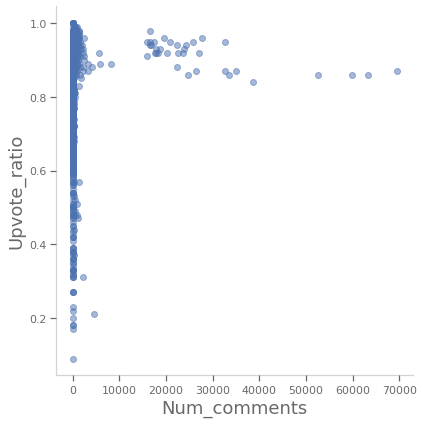

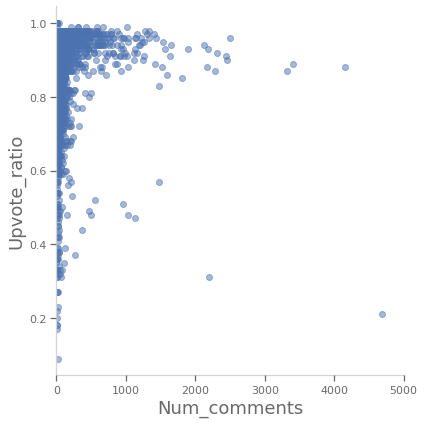

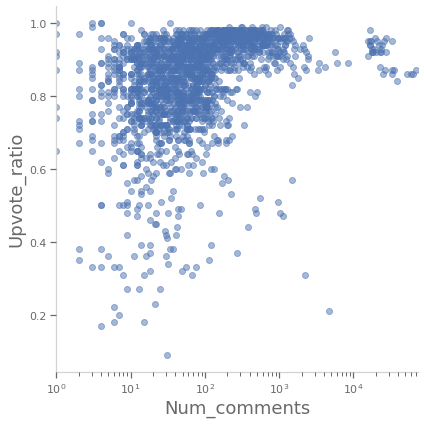

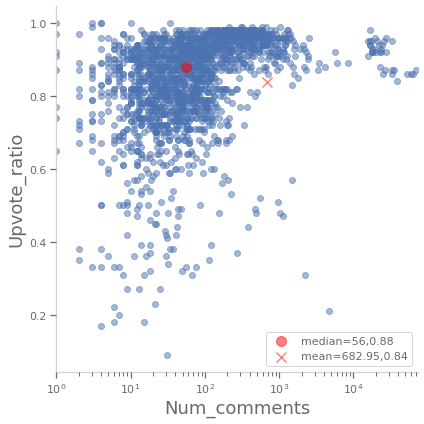

In [288]:
fig_field_by_field('num_comments','upvote_ratio')
fig_field_by_field('num_comments','upvote_ratio',xmax=5_000,xmin=0)
fig_field_by_field('num_comments','upvote_ratio',logx=True,xmin=1)
fig_field_by_field('num_comments','upvote_ratio',logx=True,xmin=1,median=True,mean=True)
#fig_field_by_field('num_comments','score',xmax=2_000,xmin=0)

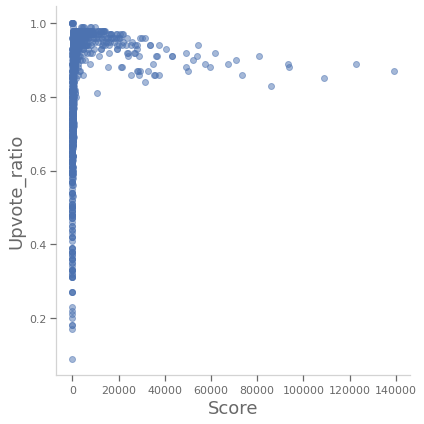

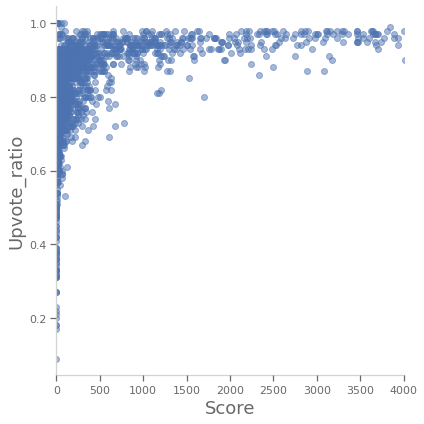

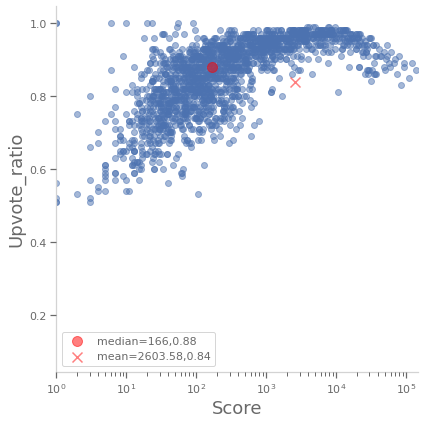

In [290]:
fig_field_by_field('score','upvote_ratio')
fig_field_by_field('score','upvote_ratio',xmax=4_000,xmin=0)
fig_field_by_field('score','upvote_ratio',xmin=1,logx=True,mean=True,median=True)

In [259]:
def count(query):
    return wsbs.count_documents(query)

In [260]:
count({'score': {'$lte':2000}})

1536

In [262]:
count({'score': {'$lte':2000}})/count({})

0.827140549273021

In [343]:
def get_days():
    first,last = getdaterange()
    diff = last['date']-first['date']
    return diff.days+diff.seconds/60/60/24
get_days()

18.13314814814815

{
            "$group":{
                "_id":"$author",
                "perday": { 
                    "$divide": [
                        {"count": { "$sum":1 }},
                        10
                    ]
                }
            }
        }

In [517]:
def get_authors(show=False, min=0, max=999_999, sortby='rate', returnDictionary=False):
    authors = wsbs.aggregate([ 
        { 
            "$group": {
                "_id": "$author",
                "count": { "$sum": 1 },
                "totalscore": { "$sum": "$score"},
                "totalcomments": { "$sum": "$num_comments"}
            } 
        },
        { 
            "$project": {
                #"author": "$author",
                "count": 1,
                "totalscore": "$totalscore",
                "totalcomments": "$totalcomments",
                "rate": { "$divide": ["$count",get_days()] },
                "avgScorePerPost": { "$divide": ["$totalscore","$count"] },
                "avgScorePerDay": { "$divide": ["$totalscore", get_days()] },
                "avgCommentsPerPost": { "$divide": ["$totalcomments","$count"] },
                "avgCommentsPerDay": { "$divide": ["$totalscore", get_days()] }
            } 
        },
        {    
            "$sort": {
                'rate':-1  
            }
        }
    ])
    i = 0
    data = dict()
    data['posters'] = []
    data['postCount'] = []
    data['postRate'] = []
    data['totalScore'] = []
    data['totalComments'] = []
    data['avgScorePerDay'] = []
    data['avgScorePerPost'] = []
    data['avgCommentsPerDay'] = []
    data['avgCommentsPerPost'] = []
    
    posters = []
    post_counts = []
    post_rates = []
    for x in authors:
        #if i > 10:
        #    return
        
        if x['count'] > 1 and show:
            pass
    
        if x['count'] >= min and x['count'] <= max:
            if show:
                print(x)
                #print(x,round(x['count'],2),round(x['rate'],2),round(x['totalscore'],2),round(x['avgScorePerPost'],2),round(x['avgScorePerDay'],2))
            i += 1
            data['postCount'].append(x['count'])
            data['posters'].append(x['_id'])
            data['postRate'].append(x['rate'])
            data['totalScore'].append(x['totalscore'])
            data['totalComments'].append(x['totalcomments'])
            data['avgScorePerDay'].append(x['avgScorePerDay'])
            data['avgScorePerPost'].append(x['avgScorePerPost'])
            data['avgCommentsPerDay'].append(x['avgCommentsPerDay'])
            data['avgCommentsPerPost'].append(x['avgCommentsPerPost'])
            
    
    if returnDictionary:
        return data
    
    return (i, data['posters'], data['postCount'], data['postRate'])
    

In [498]:
vals = get_authors(show=False,max=5,returnDictionary=True)
#len(vals[1])
vals['totalScore'][:20]

[42226,
 17857,
 2811,
 2657,
 1641,
 1336,
 379,
 27078,
 212,
 8378,
 206,
 16625,
 698,
 151,
 315,
 10530,
 2379,
 6998,
 383277,
 85]

spearman_rho=0.09782347683148238   spearman_p=7.585601158211294e-05
pearson_r=0.00039889359309085246   pearson_p=0.9871568286789053
regression; pearson r:  0.00039889359309086753 0.9871568286787795 2380.807750487787
[0.04706492453814819, 3.1062850195177805]
[2536.3303829671813, 2653.5911386286434]
spearman_rho=0.0957393033036117   spearman_p=0.00010828416120947499
pearson_r=-0.01815846575194051   pearson_p=0.4637936292457539
regression; pearson r:  -0.018158465751940613 0.46379362924532175 4147.126828886177
[0.04706492453814819, 0.8471686416866674]
[2579.6217529416076, 148.1368988482527]
spearman_rho=0.07856913456368456   spearman_p=0.0018178652124402656
pearson_r=-0.00033059190353416316   pearson_p=0.9895470506940016
regression; pearson r:  -0.00033059190353416576 0.9895470506943238 115.48718654256393
[1, 66]
[2631.069411509816, 2532.7073805507152]
spearman_rho=0.06314662116244574   spearman_p=0.015389335199977787
pearson_r=-0.03676165761067505   pearson_p=0.15862827192551315
regressi

(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:xlabel='avgCommentsPerPost', ylabel='avgScorePerPost'>)

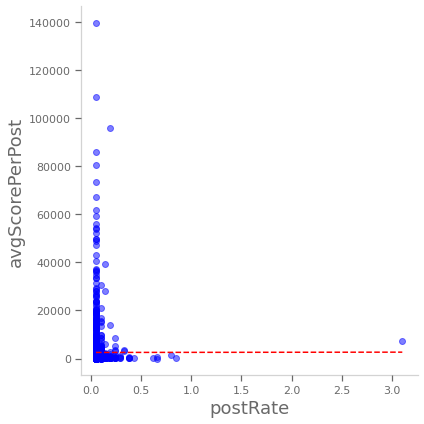

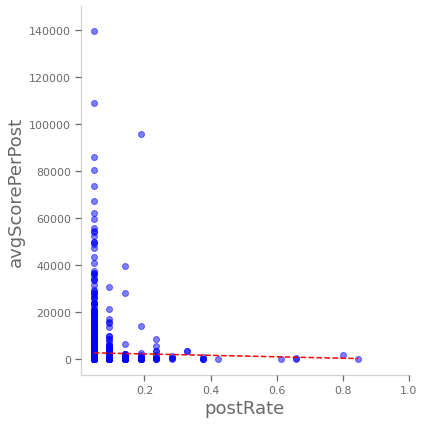

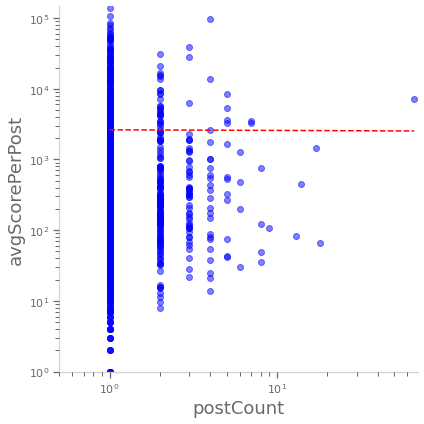

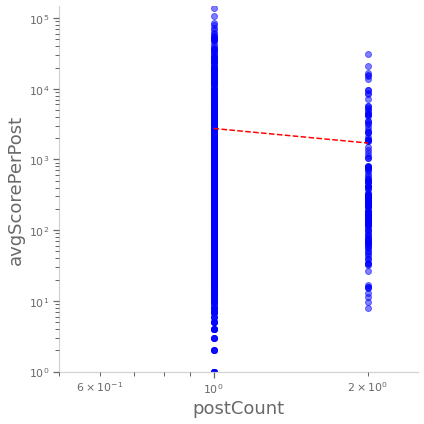

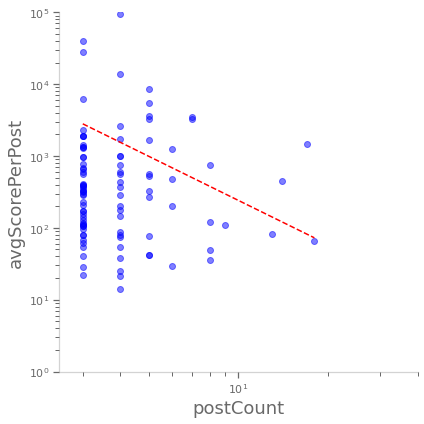

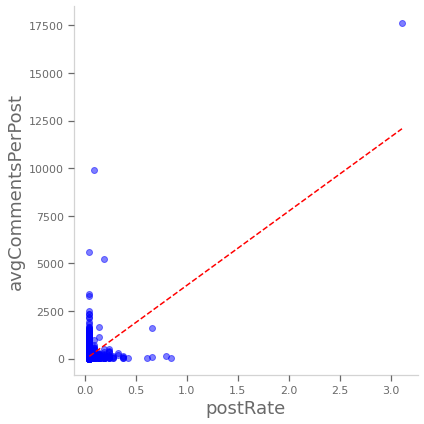

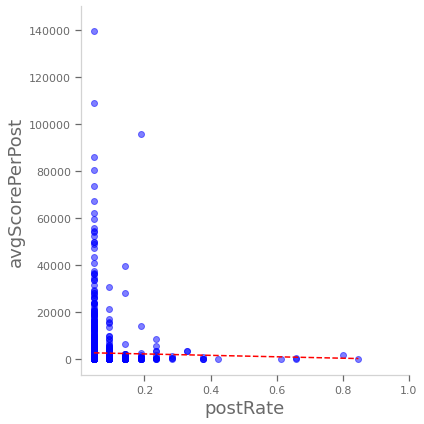

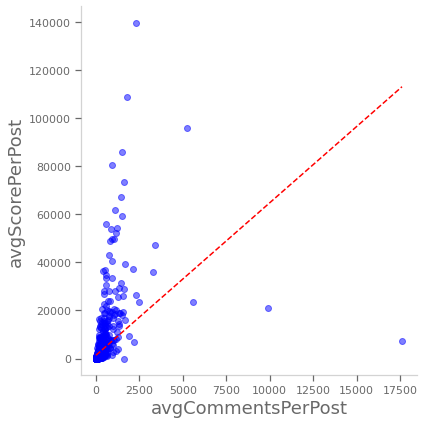

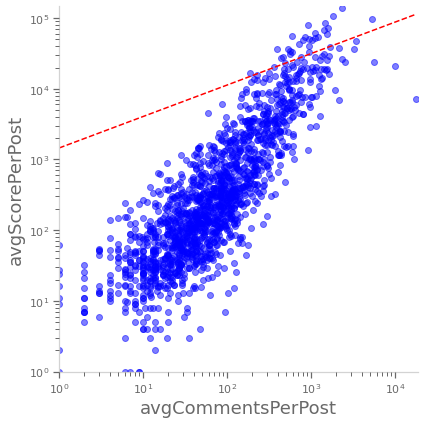

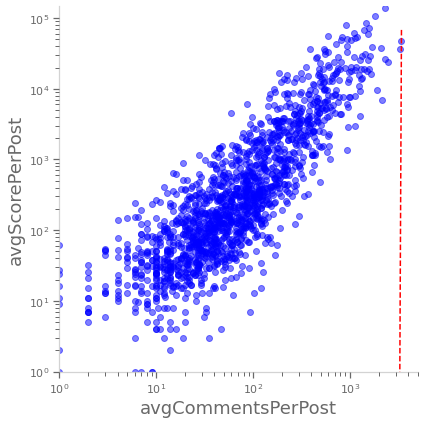

In [544]:
def graph_user_scores(data=None, fig=None, ax=None, xfield='postRate', yfield='totalScore',label=None,logx=False,logy=False,save=False,ymax=None,ymin=None,median=False,mean=False,xmax=None,xmin=None,spearman=True,pearson=True,regression=True,color='blue'):
    if data == None:
        data = get_authors(show=False,returnDictionary=True)
        
    x_master = data[xfield]
    y_master = data[yfield]
    x = []
    y = []
    for xi,yi in zip(x_master,y_master):
        if xmax and xi > xmax:
            continue
        if ymax and yi > ymax:
            continue
        if xmin and xi < xmin:
            continue
        if ymin and yi < ymin:
            continue
            
        x.append(xi)
        y.append(yi)
    
    if spearman:
        spearman_rho, spearman_p = stats.spearmanr(a=x, b=y)
        print(f'spearman_rho={spearman_rho}   spearman_p={spearman_p}')
    
    if pearson:
        pearson_r, pearson_p = stats.pearsonr(x=x, y=y)
        print(f'pearson_r={pearson_r}   pearson_p={pearson_p}')
    
    lr_m=0
    lr_b=0
    lr_r=0
    lr_p=0
    lr_stredd = 0
    if regression:
        lr_m, lr_b, lr_r, lr_p, lr_stredd = stats.linregress(x, y)
        def lr(x):
            return lr_m * x + lr_b
        print("regression; pearson r: ", lr_r, lr_p, lr_stredd)
    
    if fig == None and ax == None:
        fig, ax = plt.subplots(1,1, figsize=(6,6))
    if label:
        label += f' n={len(x)}'
    ax.scatter(x, y, alpha=.5,color=color,label=label)
    if regression:
        ax.plot(
            [min(x),max(x)], 
            [lr_m * min(x) + lr_b,lr_m * max(x) + lr_b],
            label=f'y={round(lr_m,2)}x+{round(lr_b)}, r={round(lr_r,2)} p={round(lr_p,4)}',
            c='red',
            linestyle='--'
        )
        print([min(x),max(x)])
        print([lr_m * min(x) + lr_b,lr_m * max(x) + lr_b])
    ax.set_xlabel(xfield)
    ax.set_ylabel(yfield)
    
    if median:
        median='median'
        from statistics import median
        xmedian = median(x)
        ymedian = median(y)
        ax.scatter([xmedian],[ymedian],c='red',marker='o',s=100,label=f'median={round(xmedian,2)}, {round(ymedian,2)}',alpha=.5)
    
    if mean:
        mean='mean'
        from statistics import mean
        xmean = mean(x)
        ymean = mean(y)
        ax.scatter([xmean],[ymean],c='red',marker='x',s=100,label=f'mean={round(xmean,2)}, {round(ymean,2)}',alpha=.5)
        
    if ymin!=None:
        plt.gca().set_ylim(bottom=ymin)
    if ymax:
        plt.gca().set_ylim(top=ymax)
    if xmax:
        plt.gca().set_xlim(right=xmax)
    if xmin!=None:
        plt.gca().set_xlim(left=xmin)
        
    if logx:
        plt.xscale('log')
        logx = '_logx'
    else:
        logx = ''

    if logy:
        plt.yscale('log')
        logy = '_logy'
    else:
        logy = ''
    if median or mean or label:
        ax.legend()
        
    _=plt.tight_layout()
    if save:
        filename = f'figures/postcount_by_avgscoreperpost.png'
        _=plt.savefig(filename)
        print(f'![Figure]({filename})')
        return
    return fig,ax

graph_user_scores(xfield='postRate', yfield='avgScorePerPost')#,xmax=1,ymax=150_000)
graph_user_scores(xfield='postRate', yfield='avgScorePerPost',xmax=1,ymax=150_000)
graph_user_scores(xfield='postCount', yfield='avgScorePerPost',logy=True,logx=True,ymin=1,xmin=.5)
graph_user_scores(xfield='postCount', yfield='avgScorePerPost',logy=True,logx=True,ymin=1,xmin=.5,xmax=2.5)
graph_user_scores(xfield='postCount', yfield='avgScorePerPost',logy=True,logx=True,ymin=1,xmin=2.5,xmax=40)
graph_user_scores(xfield='postRate', yfield='avgCommentsPerPost')#,xmax=1,ymax=150_000)
graph_user_scores(xfield='postRate', yfield='avgScorePerPost',xmax=1,ymax=150_000)
graph_user_scores(xfield='avgCommentsPerPost', yfield='avgScorePerPost')#,xmax=1,ymax=150_000)
graph_user_scores(xfield='avgCommentsPerPost', yfield='avgScorePerPost',logx=True, logy=True,xmin=1, ymin=1)#,xmax=1,ymax=150_000)
graph_user_scores(xfield='avgCommentsPerPost', yfield='avgScorePerPost',logx=True, logy=True,xmin=1, ymin=1,xmax=5000)#,xmax=1,ymax=150_000)



spearman_rho=0.839864267041429   spearman_p=0.0
pearson_r=0.6698040294042433   pearson_p=2.836326377842125e-170
spearman_rho=0.9171945701357467   spearman_p=3.2235508580374537e-21
pearson_r=0.3257603668170613   pearson_p=0.019661358687253966


(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:xlabel='avgCommentsPerPost', ylabel='avgScorePerPost'>)

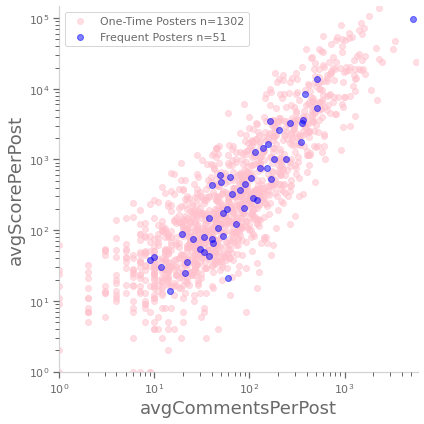

In [545]:
blue_data = get_authors(show=False,returnDictionary=True,max=1)
fig,ax = graph_user_scores(data=blue_data,xfield='avgCommentsPerPost', yfield='avgScorePerPost',logx=True, logy=True,xmin=1, ymin=1,color='pink',regression=False,label='One-Time Posters')
green_data = get_authors(show=False, returnDictionary=True,min=4)
graph_user_scores(data=green_data,fig=fig,ax=ax,xfield='avgCommentsPerPost', yfield='avgScorePerPost',logx=True, logy=True,xmin=1, ymin=1,color='blue',regression=False,label='Frequent Posters')

In [ ]:
def outcome_per_posting_hour(save=[None,None]):
    def hour_of_year(month,day,hour):
        '''given an hour, day, and month, return the number of hours since the beginning of the year'''
        dayspermonth =[0,31,28,31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        return hour + day*24 + sum(dayspermonth[:month]) * 24
    
    def add_zeros(num_hourly_submissions, num):
        '''
        adds zeros to each hourly submission until the total number of data points equals num
        '''
        for i, hour in enumerate(num_hourly_submissions):
            while len(num_hourly_submissions[i]) < num:
                num_hourly_submissions[i].append(0)
        return num_hourly_submissions
    
    def calc_avg_submissions_each_hour(num_hourly_submissions, num_days):
        '''
        given a list of submissions each hour, calculate the average number
        of submissions for each hour and return that in a list.
        
        num_days - used as the denominator in the calculation of the average
        '''
        submissions_each_hour = []
        for i, hour in enumerate(num_hourly_submissions):
            submissions_each_hour.append( sum(hour) / num_days)
        return submissions_each_hour
    
    def calc_bootstrap(num_hourly_submissions, num_samples=60_000):
        strap_space = np.zeros((24,num_samples))
        
        for hour, hour_sample_space in enumerate(num_hourly_submissions):
            for s in range(0,num_samples):
                strap_space[hour,s] = sum(random.choices(hour_sample_space,k=len(hour_sample_space))) / len(hour_sample_space)
        
        #print(strap_space)
        return strap_space
    
    dates_sorted = wsbs.aggregate( [ 
        {
            '$project': {
                'month': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%m"
                    }
                },
                'day': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%d"
                    }
                },
                'hour': {
                    '$dateToString': {
                        'date': { '$dateFromString': {'dateString': '$created_utc' } }
                        ,"format": "%H"
                    }
                }
            }
        },
        {
            "$group": { 
                '_id':{'month':'$month','day':'$day','hour':"$hour"} ,
                'numsubmissions': { '$sum':1 },
                "totalscore": { "$sum": "$score"},
                "totalcomments": { "$sum": "$num_comments"}
            }#z
            
        },
        {
            "$sort":  { '_id': 1 } # This worked when there was a groupby for only a single field
            #"$sort":  { '_id': {'day':1, 'hour':1} }
        }
    ] )
    i = 0
    hours = []
    submissions = []
    unique_days = []
    totalscore = []
    totalcomments = []
    
    
    
    #submissions_each_hour is a list of lists
    # submissions_each_hour[0] returns a list of submissions during midnight across all days
    # submissions_each_hour[1] returns a list of submissions during 1am across all days
    # and so on
    submissions_each_hour = []
    scores_each_hour = []             # this is really scores for posts created in each hour
    comments_each_hour = []           # this is really comments for posts created each hour
    for hour in range(0,24):
        submissions_each_hour.append([])
        scores_each_hour.append([])
        comments_each_hour.append([])
        
    for val in dates_sorted:
        submissions_each_hour[ int(val['_id']['hour']) ].append( int(val['numsubmissions']) )
        scores_each_hour[ int(val['_id']['hour']) ].append( int(val['totalscore']) )
        comments_each_hour[ int(val['_id']['hour']) ].append( int(val['totalcomments']) )
        hours.append(hour_of_year(int(val['_id']['month']),int(val['_id']['day']),int(val['_id']['hour'])))
        submissions.append(int(val['numsubmissions']))
        totalscore.append(int(val['totalscore']))
        totalcomments.append(int(val['totalcomments']))
        unique_day = val['_id']['month'] + val['_id']['day']
        if not unique_day in unique_days:
            unique_days.append(unique_day)
        #print(val)
        i += 1
        if i >= 10:
            pass
        #break
    
    # used to choose a denominator when calculating average submissions per hour
    most_hourly_observations = 0 
    
    for i,hour in enumerate(submissions_each_hour):
        if len(hour) > most_hourly_observations:
            most_hourly_observations = len(hour)
    submissions_each_hour = add_zeros(submissions_each_hour, most_hourly_observations)
    
    for i,hour in enumerate(scores_each_hour):
        if len(hour) > most_hourly_observations:
            most_hourly_observations = len(hour)
    scores_each_hour = add_zeros(scores_each_hour, most_hourly_observations)
    
    for i,hour in enumerate(comments_each_hour):
        if len(hour) > most_hourly_observations:
            most_hourly_observations = len(hour)
    comments_each_hour = add_zeros(comments_each_hour, most_hourly_observations)
    
    
    #for i,hour in enumerate(submissions_each_hour):
    #    print(f'{i}:{len(hour)} {hour}')
    
    def graph(data, data_per_hour,yaxis_label='Number of Submissions'):
        fig, ax = plt.subplots(1,1, figsize=(6,6))
        ax.plot(hours, data)
        ax.set_ylabel(f'{yaxis_label} (n={sum(data)})')
        ax.set_xlabel('Hour (UTC)')
        plt.gca().set_ylim(bottom=0)
        plt.tight_layout()
        if save[0]:
            plt.savefig(save[0])

        bootstrap = calc_bootstrap(data_per_hour)
        avg_data_each_hour = calc_avg_submissions_each_hour(data_per_hour, len(unique_days))
        fig, ax = plt.subplots(1,1, figsize=(6,6))
        ax.plot(range(0,24), avg_data_each_hour)
        ax.plot(range(0,24), np.percentile(bootstrap, 2.5, axis=1), c='red')
        ax.plot(range(0,24), np.percentile(bootstrap, 97.5, axis=1), c='red')
        ax.set_ylabel(f'Avg {yaxis_label} (n={sum(data)})')
        ax.set_xlabel('Hour (UTC)')
        plt.gca().set_ylim(bottom=0)
        plt.tight_layout()
        if save[1]:
            plt.savefig(save[1])

    
    
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(hours, submissions)
    ax.set_ylabel(f'Number of Submissions (n={sum(submissions)})')
    ax.set_xlabel('Hour (UTC)')
    plt.gca().set_ylim(bottom=0)
    plt.tight_layout()
    if save[0]:
        plt.savefig(save[0])
    
    bootstrap = calc_bootstrap(submissions_each_hour)
    avg_submissions_each_hour = calc_avg_submissions_each_hour(submissions_each_hour, len(unique_days))
    fig, ax = plt.subplots(1,1, figsize=(6,6))
    ax.plot(range(0,24), avg_submissions_each_hour)
    ax.plot(range(0,24), np.percentile(bootstrap, 2.5, axis=1), c='red')
    ax.plot(range(0,24), np.percentile(bootstrap, 97.5, axis=1), c='red')
    ax.set_ylabel(f'Avg Number of Submissions (n={sum(submissions)})')
    ax.set_xlabel('Hour (UTC)')
    plt.gca().set_ylim(bottom=0)
    plt.tight_layout()
    if save[1]:
        plt.savefig(save[1])
    
        
posts_per_hour()